# Trying to forecast the price series
In this notebook we will use the [Prophet](https://facebook.github.io/prophet/docs) library by Facebook to build a forecast model for the price series.


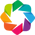

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import datetime
import poloniex
import holoviews as hv
import warnings
warnings.filterwarnings("ignore")
hv.notebook_extension('bokeh')

In [2]:
end = datetime.datetime.now()
start = end - datetime.timedelta(days=360)
ether = poloniex.get_ohlc('USDT_ETH',start, end)

In [3]:
ether.head(10)

close       high        low       open  quoteVolume  \
date                                                                           
2017-01-31 17:05:00  10.590000  10.624671  10.590000  10.624671     7.226017   
2017-01-31 17:10:00  10.589611  10.616417  10.589611  10.616417    21.021696   
2017-01-31 17:15:00  10.589600  10.594274  10.589600  10.594274    20.706674   
2017-01-31 17:20:00  10.589500  10.589600  10.589500  10.589600     1.264731   
2017-01-31 17:25:00  10.589500  10.589600  10.589500  10.589500     4.179451   
2017-01-31 17:30:00  10.589500  10.596321  10.589500  10.596321    12.913920   
2017-01-31 17:35:00  10.589500  10.589500  10.580092  10.586594   182.832652   
2017-01-31 17:40:00  10.580092  10.589500  10.580092  10.589500   331.878827   
2017-01-31 17:45:00  10.589500  10.589500  10.589500  10.589500   132.578173   
2017-01-31 17:50:00  10.599456  10.599456  10.589500  10.589500     0.021139   

                          volume  weightedAverage  
date                                               
2017-01-31 17:05:00    76.715390        10.616553  
2017-01-31 17:10:00   222.672575        10.592513  
2017-01-31 17:15:00   219.275766        10.589618  
2017-01-31 17:20:00    13.392984        10.589591  
2017-01-31 17:25:00    44.258313        10.589503  
2017-01-31 17:30:00   136.752104        10.589511  
2017-01-31 17:35:00  1936.038376        10.589128  
2017-01-31 17:40:00  3514.422370        10.589474  
2017-01-31 17:45:00  1403.936563        10.589500  
2017-01-31 17:50:00     0.224062        10.599456

## Modelando as séries

In [61]:
ether['log_close'] = np.log(ether.close)
ether['diff_log_close'] = np.log(ether.log_close.diff()+1)
ether['ds'] = ether.index
series_length = 5000

In [62]:
%%opts Curve  [height=150 width=800 tools=['hover'], interpolation='steps-pre']
c1 = hv.Curve(ether[-series_length:], ('ds','time'), ('close', 'Closing price'))
c2 = hv.Curve(ether[-series_length:], ('ds','time'), ('log_close', 'log(price)'))
c3 = hv.Curve(ether[-series_length:], ('ds','time'), ('diff_log_close', 'log(diff(price))'))
(c1+c2+c3).cols(1)

:Layout
   .Curve.I   :Curve   [ds]   (close)
   .Curve.II  :Curve   [ds]   (log_close)
   .Curve.III :Curve   [ds]   (diff_log_close)

In [72]:
models={}
for m in ['close', 'log_close', 'diff_log_close']:
#     print(m)
    df = ether[['ds', m]]
    df.columns = ['ds', 'y']
    df.reset_index(inplace=True)
    df.pop('date')
#     print(df.head())
    models[m] = Prophet(changepoint_prior_scale=0.01,
#                         yearly_seasonality=False,
#                         weekly_seasonality=False,
                       )
    models[m].add_seasonality(name='hourly', period=1/(15*24), fourier_order=5)
    models[m].fit(df.iloc[-series_length:-100]) #  Leave 10 points in the end to eveluate forecasts
    

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [73]:
future1 = models['log_close'].make_future_dataframe(periods=100, freq='5T')
future2 = models['diff_log_close'].make_future_dataframe(periods=100, freq='5T')
future1

ds
0    2018-01-09 08:20:00
1    2018-01-09 08:25:00
2    2018-01-09 08:30:00
3    2018-01-09 08:35:00
4    2018-01-09 08:40:00
5    2018-01-09 08:45:00
6    2018-01-09 08:50:00
7    2018-01-09 08:55:00
8    2018-01-09 09:00:00
9    2018-01-09 09:05:00
10   2018-01-09 09:10:00
11   2018-01-09 09:15:00
12   2018-01-09 09:20:00
13   2018-01-09 09:25:00
14   2018-01-09 09:30:00
15   2018-01-09 09:35:00
16   2018-01-09 09:40:00
17   2018-01-09 09:45:00
18   2018-01-09 09:50:00
19   2018-01-09 09:55:00
20   2018-01-09 10:00:00
21   2018-01-09 10:05:00
22   2018-01-09 10:10:00
23   2018-01-09 10:15:00
24   2018-01-09 10:20:00
25   2018-01-09 10:25:00
26   2018-01-09 10:30:00
27   2018-01-09 10:35:00
28   2018-01-09 10:40:00
29   2018-01-09 10:45:00
...                  ...
4970 2018-01-26 14:30:00
4971 2018-01-26 14:35:00
4972 2018-01-26 14:40:00
4973 2018-01-26 14:45:00
4974 2018-01-26 14:50:00
4975 2018-01-26 14:55:00
4976 2018-01-26 15:00:00
4977 2018-01-26 15:05:00
4978 2018-01-26 15:10:00
4979 2018-01-26 15:15:00
4980 2018-01-26 15:20:00
4981 2018-01-26 15:25:00
4982 2018-01-26 15:30:00
4983 2018-01-26 15:35:00
4984 2018-01-26 15:40:00
4985 2018-01-26 15:45:00
4986 2018-01-26 15:50:00
4987 2018-01-26 15:55:00
4988 2018-01-26 16:00:00
4989 2018-01-26 16:05:00
4990 2018-01-26 16:10:00
4991 2018-01-26 16:15:00
4992 2018-01-26 16:20:00
4993 2018-01-26 16:25:00
4994 2018-01-26 16:30:00
4995 2018-01-26 16:35:00
4996 2018-01-26 16:40:00
4997 2018-01-26 16:45:00
4998 2018-01-26 16:50:00
4999 2018-01-26 16:55:00

[5000 rows x 1 columns]

In [74]:
forecast1 = models['log_close'].predict(future1)

In [75]:
len(forecast1)

5000

In [76]:
forecast2 = models['diff_log_close'].predict(future2)

In [77]:
%%opts Curve  [height=600 width=800 xaxis=None tools=['hover'], interpolation='steps-pre']
%%opts Spread (fill_color='blue' fill_alpha=0.1)
c1 = hv.Curve(ether[-series_length:], ('ds','time'), ('log_close', 'log(price)'))
c2 = hv.Curve(forecast1, ('ds','time'), ('yhat', 'predicted'))
c3 = hv.Spread((forecast1.ds,(forecast1.yhat_lower), (forecast1.yhat_upper-forecast1.yhat)))
c1*c2#*c3

:Overlay
   .Curve.I  :Curve   [ds]   (log_close)
   .Curve.II :Curve   [ds]   (yhat)

In [78]:
%%opts Curve  [height=600 width=800 xaxis=None tools=['hover'], interpolation='steps-pre']
%%opts Spread (fill_color='blue' fill_alpha=0.1)
c1 = hv.Curve(ether[-series_length:], ('ds','time'), ('diff_log_close', 'log(diff(price))'))
c2 = hv.Curve(forecast2, ('ds','time'), ('yhat', 'predicted'))
c3 = hv.Spread((forecast2.ds,forecast2.yhat_lower, forecast2.yhat_upper))
c1*c2#*c3

:Overlay
   .Curve.I  :Curve   [ds]   (diff_log_close)
   .Curve.II :Curve   [ds]   (yhat)

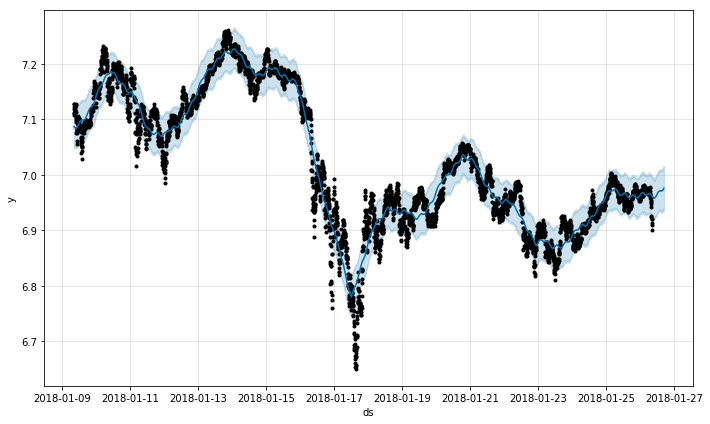

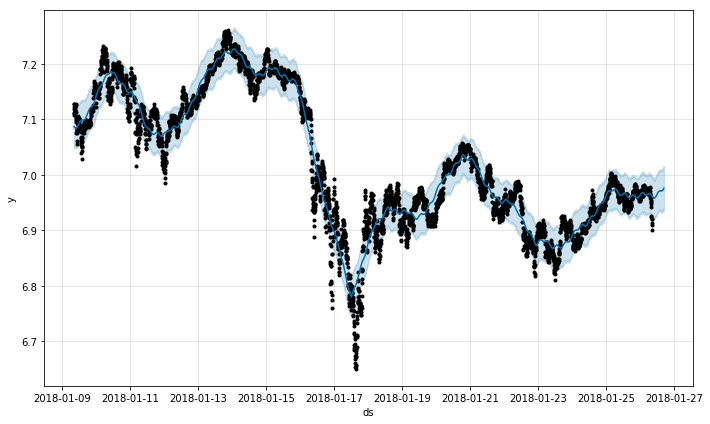

In [79]:
models['log_close'].plot(forecast1)

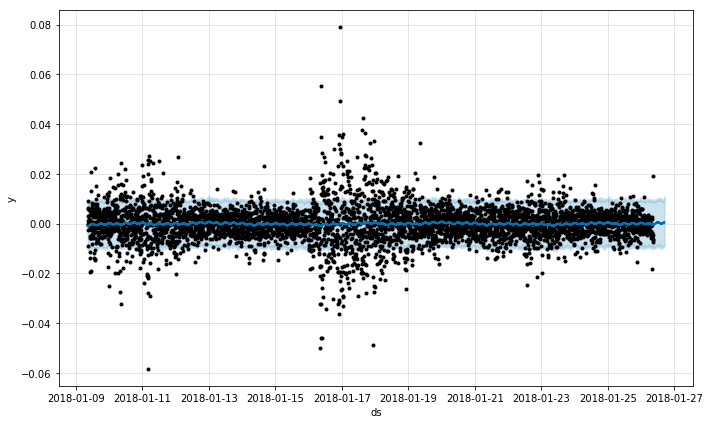

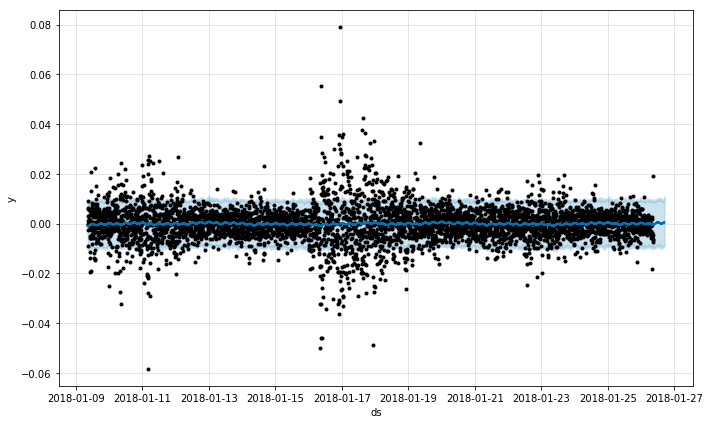

In [80]:
models['diff_log_close'].plot(forecast2)

In [79]:
forecast1.head()

ds     trend  trend_lower  trend_upper  yhat_lower  \
0 2017-12-22 20:00:00  6.455322     6.455322     6.455322    6.450040   
1 2017-12-22 20:05:00  6.455250     6.455250     6.455250    6.450813   
2 2017-12-22 20:10:00  6.455177     6.455177     6.455177    6.448245   
3 2017-12-22 20:15:00  6.455105     6.455105     6.455105    6.452136   
4 2017-12-22 20:20:00  6.455032     6.455032     6.455032    6.453902   

   yhat_upper     daily  daily_lower  daily_upper  seasonal  seasonal_lower  \
0    6.534158 -0.001484    -0.001484    -0.001484  0.036140        0.036140   
1    6.531373 -0.001492    -0.001492    -0.001492  0.036371        0.036371   
2    6.529019 -0.001511    -0.001511    -0.001511  0.036591        0.036591   
3    6.528730 -0.001542    -0.001542    -0.001542  0.036799        0.036799   
4    6.534587 -0.001583    -0.001583    -0.001583  0.036997        0.036997   

   seasonal_upper  seasonalities  seasonalities_lower  seasonalities_upper  \
0        0.036140       0.036140             0.036140             0.036140   
1        0.036371       0.036371             0.036371             0.036371   
2        0.036591       0.036591             0.036591             0.036591   
3        0.036799       0.036799             0.036799             0.036799   
4        0.036997       0.036997             0.036997             0.036997   

     weekly  weekly_lower  weekly_upper      yhat  
0  0.037624      0.037624      0.037624  6.491462  
1  0.037863      0.037863      0.037863  6.491621  
2  0.038102      0.038102      0.038102  6.491768  
3  0.038341      0.038341      0.038341  6.491904  
4  0.038580      0.038580      0.038580  6.492029

In [93]:
df_cv = cross_validation(models['log_close'], horizon = '1 day')
df_cv.head()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_

SystemError: <class 'stanfit4anon_model_1fdd477dd8bcc50395c4e25c8741f1c1_191536462240061358.PyStanHolder'> returned a result with an error set

In [100]:
Prophet?

In [44]:
models['log_close'].

{'beta': array([[0.]]),
 'delta': array([[-0.03763261, -0.12805257,  0.35523276,  0.02919881, -0.37379689,
          0.22413311, -0.27914765,  0.2411319 , -0.05797332,  0.13785472,
         -0.15070906,  0.16523213, -0.0911541 , -0.15391237,  0.20088317,
         -0.09530554,  0.09918678,  0.02360529, -0.11829741, -0.12664574,
          0.13177752, -0.09812249,  0.05705104,  0.11842564, -0.08983346]]),
 'gamma': array([[ 0.00121396,  0.00826146, -0.03398222, -0.00373511,  0.05987403,
         -0.04313129,  0.06272283, -0.06169114,  0.01670199, -0.04416258,
          0.05314213, -0.06359323,  0.03792173,  0.0689952 , -0.09653118,
          0.04887192, -0.05406176, -0.01360127,  0.07197851,  0.08114344,
         -0.08868232,  0.06919873, -0.04201089, -0.09102572,  0.07194671]]),
 'k': array([[0.01589718]]),
 'm': array([[0.97958559]]),
 'sigma_obs': array([[0.00132677]])}

In [84]:
%%opts Spread (fill_color='indianred' fill_alpha=1)
xs = np.linspace(0, np.pi*2, 20)
hv.Spread((xs, np.sin(xs), 0.1+np.random.rand(len(xs)), 0.1+np.random.rand(len(xs))),
          vdims=['y', 'yerrneg', 'yerrpos'])


:Spread   [x]   (y,yerrneg,yerrpos)

In [12]:
pd.__version__

'0.19.2'